### Importing libraries

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

In [7]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("models-experiment")

<Experiment: artifact_location='file:///d:/Study/Conda Projects/mlops-zoom/02-exp-tracking/mlruns/2', creation_time=1716832980298, experiment_id='2', last_update_time=1716832980298, lifecycle_stage='active', name='models-experiment', tags={}>

### Reading the dataset

In [8]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    # Creating the target variable: duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # Converting duration into minutes
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

    df = df[((df['duration'] >= 1) & (df['duration'] <= 60))]

    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID']+"_"+df['DOLocationID']

    return df

In [9]:
df_train = read_dataframe("D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-01.parquet")

In [10]:
df_val = read_dataframe("D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-02.parquet")

In [11]:
len(df_train),len(df_val)

(65946, 62574)

### Exploring the dataset

In [1]:
df_train.head()

NameError: name 'df_train' is not defined

In [13]:
df_train.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
PU_DO                            object
dtype: object

In [14]:
df_train['duration'].head()

0    11.016667
1     6.766667
2     6.333333
3     5.816667
4     5.966667
Name: duration, dtype: float64

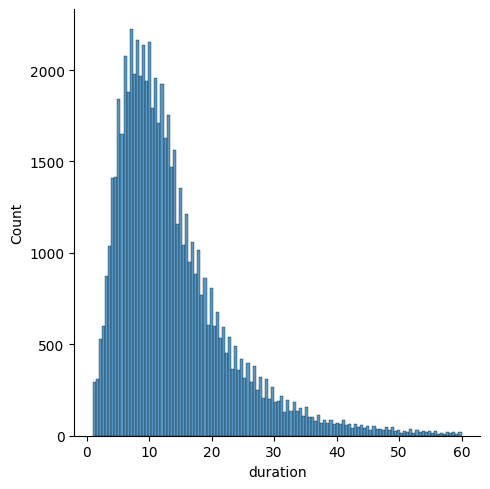

In [15]:
sns.displot(df_train['duration'])

In [16]:
df_train['duration'].describe(percentiles=[0.95,0.98,0.99])

count    65946.000000
mean        13.747575
std          9.023810
min          1.000000
50%         11.533333
95%         31.816667
98%         40.501667
99%         46.592500
max         60.000000
Name: duration, dtype: float64

### Training and Validation Set

In [12]:
categorical = ['PU_DO']
numerical = ['trip_distance']

In [13]:
df_train.shape, df_val.shape

((65946, 22), (62574, 22))

In [14]:
dv = DictVectorizer()
train_dicts = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target='duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
mlflow.autolog()

2024/05/27 11:19:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [52]:
with mlflow.start_run():
    mlflow.log_param("train-data-path","D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path","D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-02.parquet")

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)

    mlflow.log_metric("rmse",rmse)

    mlflow.sklearn.log_model(lr, artifact_path="models_mlflow")

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [37]:
with mlflow.start_run():
    mlflow.set_tag("developer","Anish")

    mlflow.log_param("train-data-path","D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path","D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    # Lasso Regression
    lasso = Lasso()
    lasso.fit(X_train,y_train)
    y_pred = lasso.predict(X_val)
    rmse = mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)

    mlflow.log_metric("rmse",rmse)

    # Saving the model as an artifact
    mlflow.log_artifact(local_path="D:\Study\Conda Projects\mlops-zoom\\02-exp-tracking\models\lr_model.bin", artifact_path="models_pickle")

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
sns.histplot(data=y_pred,kde=True,label='Prediction')
sns.histplot(data=y_train,kde=True,label='actual')
plt.legend()
plt.show()

### Saving the Model

In [22]:
import pickle

In [23]:
with open('D:\Study\Conda Projects\mlops-zoom\\02-exp-tracking\models\lr_model.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

### MLFLow Sample Run

In [28]:
import xgboost as xgb

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [30]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [31]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [32]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [ ]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [53]:
mlflow.xgboost.autolog()
with mlflow.start_run():
    params = {
            'learning_rate': 0.09585355369315604,
            'max_depth': 30,
            'min_child_weight': 1.060597050922164,
            'objective': 'reg:linear',
            'reg_alpha': 0.018060244040060163,
            'reg_lambda': 0.011658731377413597,
            'seed': 42
        }

    
    mlflow.log_params(params)

    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=100,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_true=y_val,y_pred=y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv,f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [11:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.73788
[1]	validation-rmse:8.22960
[2]	validation-rmse:7.78914
[3]	validation-rmse:7.40823
[4]	validation-rmse:7.08398
[5]	validation-rmse:6.80130
[6]	validation-rmse:6.56559
[7]	validation-rmse:6.35942
[8]	validation-rmse:6.18716
[9]	validation-rmse:6.04364
[10]	validation-rmse:5.91994
[11]	validation-rmse:5.81441
[12]	validation-rmse:5.72701
[13]	validation-rmse:5.65236
[14]	validation-rmse:5.58821
[15]	validation-rmse:5.53629
[16]	validation-rmse:5.49451
[17]	validation-rmse:5.45443
[18]	validation-rmse:5.42147
[19]	validation-rmse:5.39347
[20]	validation-rmse:5.37267
[21]	validation-rmse:5.35128
[22]	validation-rmse:5.33257
[23]	validation-rmse:5.31780
[24]	validation-rmse:5.30449
[25]	validation-rmse:5.29542
[26]	validation-rmse:5.28365
[27]	validation-rmse:5.27505
[28]	validation-rmse:5.26725
[29]	validation-rmse:5.26004
[30]	validation-rmse:5.25388
[31]	validation-rmse:5.24812
[32]	validation-rmse:5.24406
[33]	validation-rmse:5.24068
[34]	validation-rmse:5.2

2024/05/27 11:10:48 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 11:10:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [11:10:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/27 11:11:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `

### Loading the MLFlow saved model

In [41]:
logged_model = 'runs:/72e5c09fb0b1429188dc384b0d9bbc5a/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [10:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [42]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 72e5c09fb0b1429188dc384b0d9bbc5a

In [43]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\xgboost\core.py:160: UserWarning: [10:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [44]:
xgboost_model

### Model Registry

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

# mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-01.parquet")
        mlflow.log_param("valid-data-path", "D:\Study\Conda Projects\mlops-zoom\data\green\green_tripdata_2023-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/05/27 11:20:24 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/05/27 11:25:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
2024/05/27 11:26:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
d:\Study\Conda Projects\mlops-zoom\mlops\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4